In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
from cycler import cycler
from tcr_processing import *
import datetime
import csv

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [9]:
class TCR:
    '''Create a class object for loading, processing 
        and clustering 10X TCR data with Scirpy'''
    
    def __init__(self, parameters):
        print('Initialising class object')

        assert type(parameters)==dict

        self.params = parameters
    
    def load_data(self):

        '''Load 10X transcriptomic and cell binding data'''
        
        print('Loading TCR binding and transcriptomics data')
        
        contigs, feature_matrix= [self.params[x] for x in ['contigs','bc_matrix']]
        
        if not contigs[-3:]=='csv':
            raise TypeError('Contigs file should be in csv format')

        if not feature_matrix[-2:]=='h5':
            raise TypeError('Contigs file should be in h5 format')
        
        # Load TCR data
        adata_tcr = ir.io.read_10x_vdj(contigs)

        # Load associated transcriptomics data
        adata = sc.read_10x_h5(feature_matrix)

        # Merge
        ir.pp.merge_with_ir(adata, adata_tcr)

        print("Data loaded to Ann Object with shape: ",adata.shape)
        
        self.adata=adata

    def drop_dead(self):
        '''Remove cells above a set % of mitochondrial gene expression 
            or falling above a total gene count threshold'''
        
        max_genes, mito_cutoff= [self.params[x] for x in ['max_genes','mito_cutoff']]
        if mito_cutoff:
            print('Eliminating cells above mitochondrial gene expression threshold')
            self.adata.var['mt'] = self.adata.var_names.str.startswith('MT-')  # Generates a boolean mask for genes starting with 'MT'
            sc.pp.calculate_qc_metrics(self.adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)  # Returns total_counts_['mt'] for vars fed in via qc_vars
            self.adata = self.adata[self.adata.obs.pct_counts_mt < mito_cutoff, :]

        if max_genes:
            print('Eliminating suspected doublets')
            self.adata = self.adata[self.adata.obs.n_genes_by_counts < max_genes, :]

    def preprocess(self):
        '''Preprocess single cell data and conduct TCR chain quality control'''

        if self.params['preprocess']==True:

            min_cells, min_genes = [self.params[x] for x in ['min_cells','min_genes']]
        
            # Filter dead and doublet cells

            if min_cells:
                sc.pp.filter_genes(self.adata, min_cells=min_cells)
            if min_genes:
                sc.pp.filter_cells(self.adata, min_genes=min_genes)
            
            self.drop_dead()

            # Normalise count data
            sc.pp.normalize_per_cell(self.adata, counts_per_cell_after=1000)
            sc.pp.log1p(self.adata)

        # QC of TCR chains
    
        ir.tl.chain_qc(self.adata)
        
        print(
            "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
                np.sum(self.adata.obs["chain_pairing"].isin(
                        ["extra VJ", "extra VDJ", "two full chains"])) / self.adata.n_obs))
        print('Dropping multichain and single chain receptors')

        # Drop multichain instances
        self.adata = self.adata[self.adata.obs["chain_pairing"] != "multichain", :].copy()

        # Drop single chain instances
        self.adata = self.adata[~self.adata.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()
    
    def get_epitopes(self):

        '''Extract epitope map from binarized matrix file'''
        binarized_matrix, epitopes_loadfile, epitopes_outfile=[self.params[x] for x in ['binarized_matrix',
                                                                                            'epitopes_loadfile',
                                                                                            'epitopes_outfile']]
        if epitopes_loadfile:
            epitopes=load_pickle(epitopes_loadfile)
        
        elif epitopes_outfile and not epitopes_loadfile:

            print('Loading binary matrix')
            binary_matrix=pd.read_csv(binarized_matrix)
            sub=binary_matrix[binary_matrix.columns[68:]]   # Check this for other donors
            sub.set_index(binary_matrix['barcode'].values,inplace=True)
            print('Reading epitope specificity from %s cells'%(len(sub)))
            eps=[sub.iloc[i][sub.iloc[i]==True] for i in range(len(sub))]
            assert len(eps)==len(sub)
            epitopes={}
            for i in range(len(eps)):
                try:
                    epitopes[eps[i].name]=eps[i].index[0].strip('_binder')
                except IndexError:
                    epitopes[eps[i].name]='None'
            save_pickle(epitopes,epitopes_outfile)
            
        else:
            raise ValueError("You must specify either a pre-existing epitope file, or an epitopes outfile location")
        
        self.epitopes=epitopes

    def get_clusters(self):

        '''Generate baseline clusters using scirpy clustering function'''

        dist=self.params['cluster_distance']
        if dist not in ['identity', 'hamming', 'levenshtein']:
            raise ValueError('Enter a distance metric from "identity", "hamming", "levenshtein"')

        ir.pp.ir_dist(
            self.adata,
            metric=dist,
            cutoff=1,
            sequence="aa",
        )
        ir.tl.define_clonotype_clusters(self.adata, sequence='aa', metric=dist, receptor_arms='all', dual_ir='primary_only', same_v_gene=False, n_jobs=4)
        ir.tl.clonotype_network(self.adata, sequence='aa', metric=dist,min_cells=2) 
        idx = {x:k for k in self.adata.uns['cc_aa_%s'%(dist)]['cell_indices'].keys() for x in self.adata.uns['cc_aa_%s'%(dist)]['cell_indices'][k]}
        clusts= []
        tcr=self.adata.uns['TCRs']
        for i in range(len(tcr)):
            barcode = tcr.iloc[i].name
            if barcode in idx.keys():
                clusts.append(idx[barcode])
            else:
                clusts.append('None')
        assert len(clusts)==len(tcr)
        tcr['scirpy_%s'%(dist)]=clusts
        self.adata.uns['TCRs']=tcr
            
    def get_TCRs(self):

        '''Extract TCRs from Ann object, and map to epitope specificity'''
        TCR = self.adata.obs[['IR_VDJ_1_junction_aa','IR_VDJ_1_v_call','IR_VDJ_1_j_call',
                              'IR_VDJ_1_consensus_count','IR_VDJ_1_productive','IR_VDJ_1_duplicate_count',
                              'IR_VJ_1_junction_aa','IR_VJ_1_v_call','IR_VJ_1_j_call',
                              'IR_VJ_1_consensus_count','IR_VJ_1_productive','IR_VJ_1_duplicate_count']].copy()
        
        TCR.columns=['cdr3.beta','v.beta','j.beta','count_beta','productive_beta','duplicates_beta',
                     'cdr3.alpha','v.alpha','j.alpha','count_alpha','productive_alpha','duplicates_alpha']

        epitope_dict=self.epitopes
        eps=[]
        for i in range(len(TCR)):
                if TCR.iloc[i].name in epitope_dict.keys():
                    eps.append(epitope_dict[TCR.index[i]])
                else:
                    eps.append('None')
        TCR['Epitope']=eps
        TCR['subject:condition']=self.params['subj']

        self.adata.uns['TCRs']=TCR

        if self.params['cluster_distance']:
            self.get_clusters()
        else:
            self.params['cluster_distance']='None'
        
        if self.params['tcr_outfile']:
            print('Saving')
            TCR.to_pickle(self.params['tcr_outfile'])

def write_record(record,parameters):
    '''Write parameters to csv file'''
    print('Recording parameters to: ',record)
    with open(record,'a') as f:
        writer=csv.writer(f)
        writer.writerow(list(parameters.values()))    


In [10]:
def run(parameter_dict,record):
    tcr_obj=TCR(parameter_dict)
    tcr_obj.load_data()
    tcr_obj.preprocess()
    tcr_obj.get_epitopes()
    tcr_obj.get_TCRs()
    if parameter_dict['h5_outfile']:
        tcr_obj.adata.write_h5ad(parameter_dict['h5_outfile'])
    write_record(record,tcr_obj.params)
    print('Complete\n')   

In [5]:
# Execute for single donor

donor =2

time=datetime.datetime.now().strftime('%Y%m%d_%H%M')
record='data/record.csv'

parameter_dict=dict(
tcr_outfile="%s_TCRs_donor2.pkl"%(time),
contigs="data/vdj_v1_hs_aggregated_donor2_all_contig_annotations.csv",
bc_matrix="data/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.h5",
binarized_matrix='data/vdj_v1_hs_aggregated_donor2_binarized_matrix.csv',
preprocess=True,
min_cells=10,
min_genes=100,
max_genes=2500,
mito_cutoff=5,
epitopes_loadfile=None,
epitopes_outfile="%s_epitopes_donor2.pkl"%(time),
h5_outfile="%s_TCRs_donor_%s.h5ad"%(time,donor),
subj='donor2:healthy',
organism='homo sapiens',
cluster_distance='hamming')

# run(parameter_dict,record)


Initialising class object
Loading TCR binding and transcriptomics data
reading data/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:05)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/danhudson/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/Users/danhudson/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


Data loaded to Ann Object with shape:  (91921, 33538)
Fraction of cells with more than one pair of TCRs: 0.07
Dropping multichain and single chain receptors


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Loading binary matrix
Reading epitope specificity from 77854 cells
Saving file to  20220124_0955_epitopes_donor2.pkl
Computing sequence x sequence distance matrix for VJ sequences.


100%|██████████| 22366/22366 [00:10<00:00, 2092.22it/s] 


Computing sequence x sequence distance matrix for VDJ sequences.


100%|██████████| 24976/24976 [00:10<00:00, 2393.52it/s] 


Initializing lookup tables. 
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


100%|██████████| 12921/12921 [00:15<00:00, 833.92it/s] 


Stored clonal assignments in `adata.obs["cc_aa_hamming"]`.
Saving
Recording parameters to:  data/record.csv
Complete


In [19]:
time=datetime.datetime.now().strftime('%Y%m%d_%H%M')

for d in range(1,5):

    donor = str(d)
    record='data/record_merged.csv'
    parameter_dict=dict(
    tcr_outfile="%s_TCRs_donor_%s.pkl"%(time,donor),
    contigs="data/donor%s/vdj_v1_hs_aggregated_donor%s_all_contig_annotations.csv"%(donor,donor),
    bc_matrix="data/donor%s/vdj_v1_hs_aggregated_donor%s_filtered_feature_bc_matrix.h5"%(donor,donor),
    binarized_matrix='data/donor%s/vdj_v1_hs_aggregated_donor%s_binarized_matrix.csv'%(donor,donor),
    preprocess=True,
    min_cells=10,
    min_genes=100,
    max_genes=2500,
    mito_cutoff=5,
    epitopes_loadfile=None,
    epitopes_outfile="%s_epitopes_donor%s.pkl"%(time,donor),
    h5_outfile="%s_TCRs_donor_%s.h5ad"%(time,donor),
    subj='donor%s:healthy'%(donor),
    organism='homo sapiens',
    cluster_distance=None)

    run(parameter_dict,record)

Initialising class object
Loading TCR binding and transcriptomics data
reading data/donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


Data loaded to Ann Object with shape:  (55206, 33538)
filtered out 16156 genes that are detected in less than 10 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 7 cells that have less than 100 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Eliminating cells above mitochondrial gene expression threshold
Eliminating suspected doublets
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Fraction of cells with more than one pair of TCRs: 0.16
Dropping multichain and single chain receptors


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Loading binary matrix
Reading epitope specificity from 46526 cells
Saving file to  20220201_1101_epitopes_donor1.pkl


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_subtype' as categorical


Saving


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'chain_pairing' as categorical


Recording parameters to:  data/record_merged.csv
Complete
Initialising class object
Loading TCR binding and transcriptomics data
reading data/donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:18)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


Data loaded to Ann Object with shape:  (91921, 33538)
filtered out 15493 genes that are detected in less than 10 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 11 cells that have less than 100 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Eliminating cells above mitochondrial gene expression threshold
Eliminating suspected doublets
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Fraction of cells with more than one pair of TCRs: 0.07
Dropping multichain and single chain receptors


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Loading binary matrix
Reading epitope specificity from 77854 cells
Saving file to  20220201_1101_epitopes_donor2.pkl


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_subtype' as categorical


Saving


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'chain_pairing' as categorical


Recording parameters to:  data/record_merged.csv
Complete
Initialising class object
Loading TCR binding and transcriptomics data
reading data/donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


Data loaded to Ann Object with shape:  (54137, 33538)
filtered out 16839 genes that are detected in less than 10 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 1311 cells that have less than 100 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Eliminating cells above mitochondrial gene expression threshold
Eliminating suspected doublets
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Fraction of cells with more than one pair of TCRs: 0.08
Dropping multichain and single chain receptors


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Loading binary matrix
Reading epitope specificity from 37824 cells
Saving file to  20220201_1101_epitopes_donor3.pkl


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_subtype' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versi

Saving
Recording parameters to:  data/record_merged.csv
Complete
Initialising class object
Loading TCR binding and transcriptomics data
reading data/donor4/vdj_v1_hs_aggregated_donor4_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


Data loaded to Ann Object with shape:  (36619, 33538)
filtered out 17259 genes that are detected in less than 10 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 1515 cells that have less than 100 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Eliminating cells above mitochondrial gene expression threshold
Eliminating suspected doublets
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Fraction of cells with more than one pair of TCRs: 0.08
Dropping multichain and single chain receptors


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Loading binary matrix
Reading epitope specificity from 27308 cells
Saving file to  20220201_1101_epitopes_donor4.pkl


/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_subtype' as categorical
/opt/miniconda3/envs/10X/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versi

Saving
Recording parameters to:  data/record_merged.csv
Complete


In [20]:
def merge_donors(root,datetime_tag,parameter_dict,record):
    merged=pd.DataFrame()
    for donor in range(1,5):
        input_file=root+'%s_TCRs_donor_%s.pkl'%(datetime_tag,str(donor))
        df = load_pickle(input_file)
        merged=pd.concat([merged,df])
    print('Saving merged files')
    savefile='%s_TCRs_merged.pkl'%(datetime_tag)
    merged.to_pickle(savefile)
    parameter_dict['tcr_outfile']=savefile
    print('Exporting record')
    for key in ['contigs','bc_matrix','binarized_matrix','epitopes_outfile','h5_outfile','subj']:
        parameter_dict[key]='Multiple'
    if not parameter_dict['cluster_distance']:
        parameter_dict['cluster_distance']='None'
    write_record(record,parameter_dict)    

root='/Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/'
datetime_tag='20220201_1101'

merge_donors(root,datetime_tag,parameter_dict,record)

Loading files from /Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/20220201_1101_TCRs_donor_1.pkl
Loading files from /Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/20220201_1101_TCRs_donor_2.pkl
Loading files from /Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/20220201_1101_TCRs_donor_3.pkl
Loading files from /Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/20220201_1101_TCRs_donor_4.pkl
Saving merged files
Exporting record
Recording parameters to:  data/record_merged.csv


In [11]:
# filter out duplicates and nans

loadfile=root+time+'_TCRs_merged.pkl'
merged=load_pickle(loadfile)
filt=merged.dropna().drop_duplicates()
print('Dropping %s files of %s'%(len(merged)-len(filt),len(merged)))
print('Saving')
filt.to_pickle(root+time+'_TCRs_merged_filtered.pkl')
print('Complete')

Loading files from /Users/danhudson/Documents/Academic/Oxford/Oxford_DPhil/Rotation_Projects/Hashem/10X_pipeline/20220201_1008_TCRs_merged.pkl
Dropping 5464 files of 61627
Saving
Complete


Removing 8679 duplicates and 8680 NaNs for donor 1
Removing 14066 duplicates and 14067 NaNs for donor 2
Removing 16312 duplicates and 16313 NaNs for donor 3
Removing 9310 duplicates and 9311 NaNs for donor 4


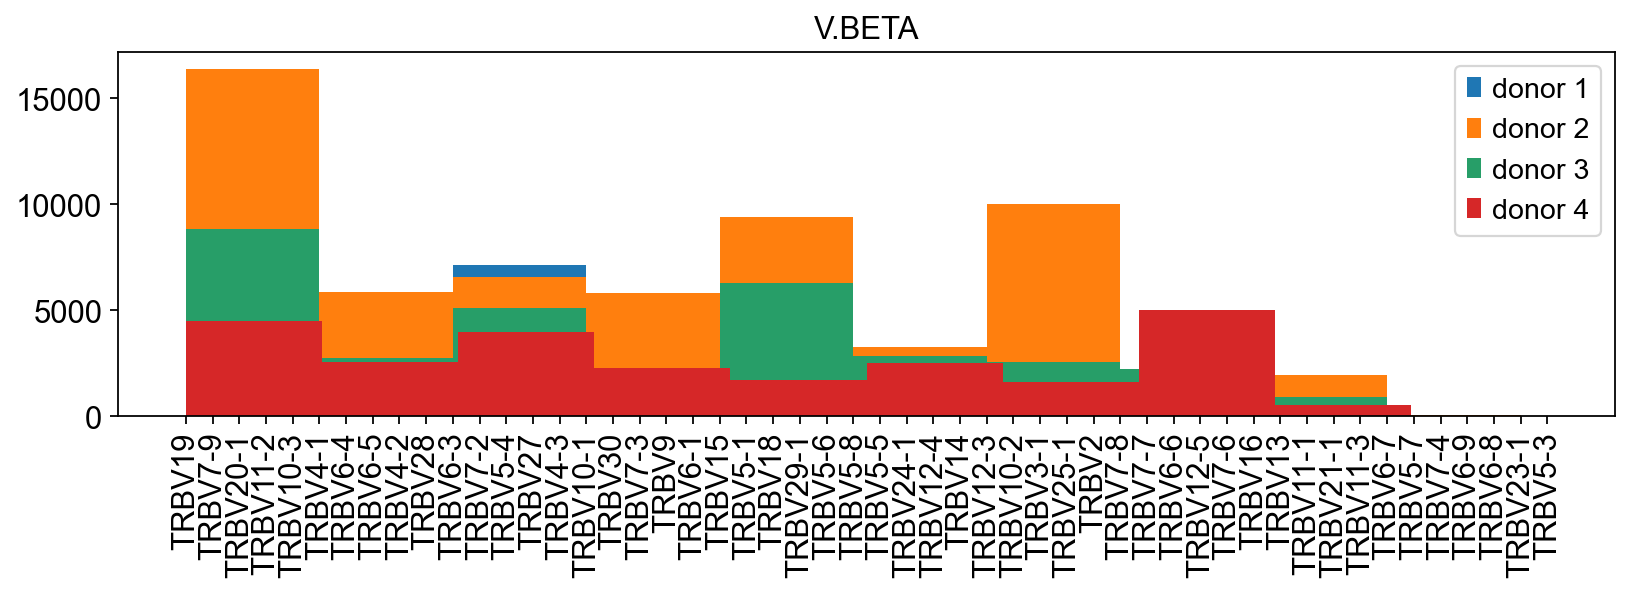

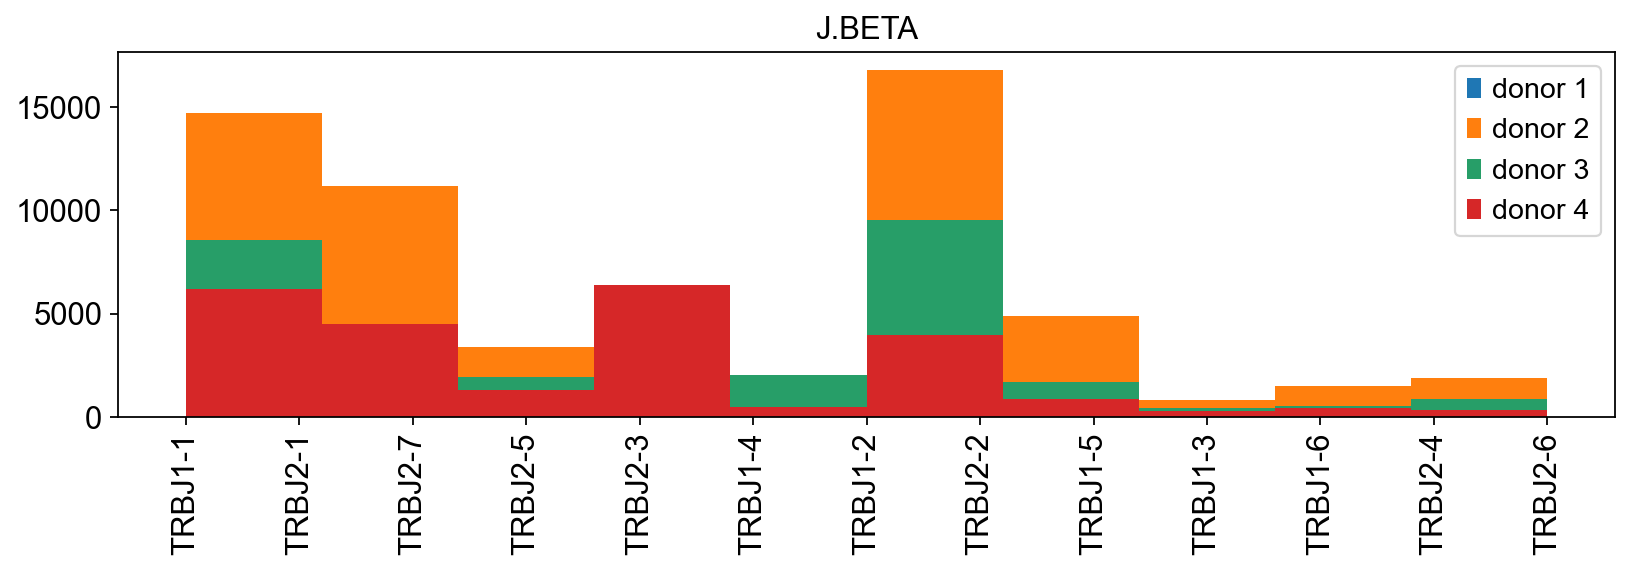

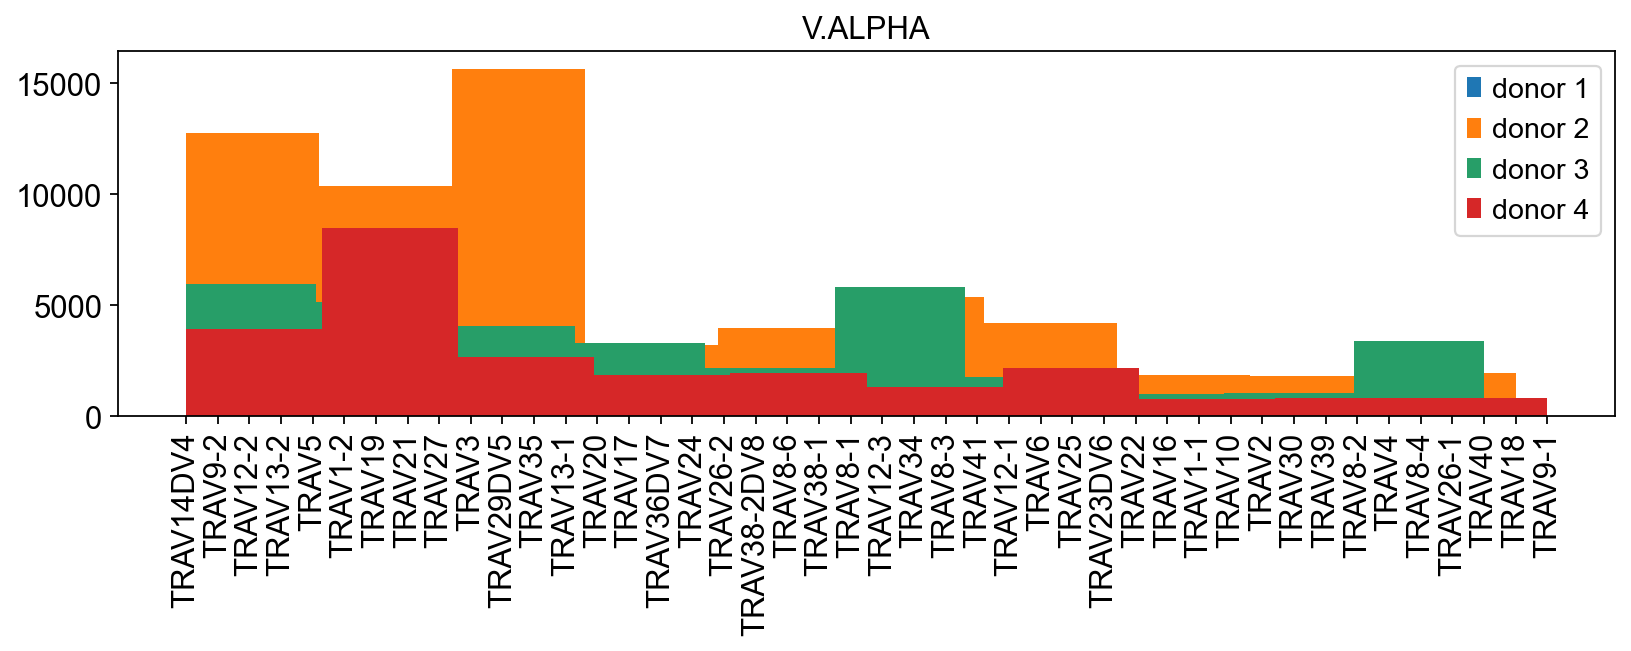

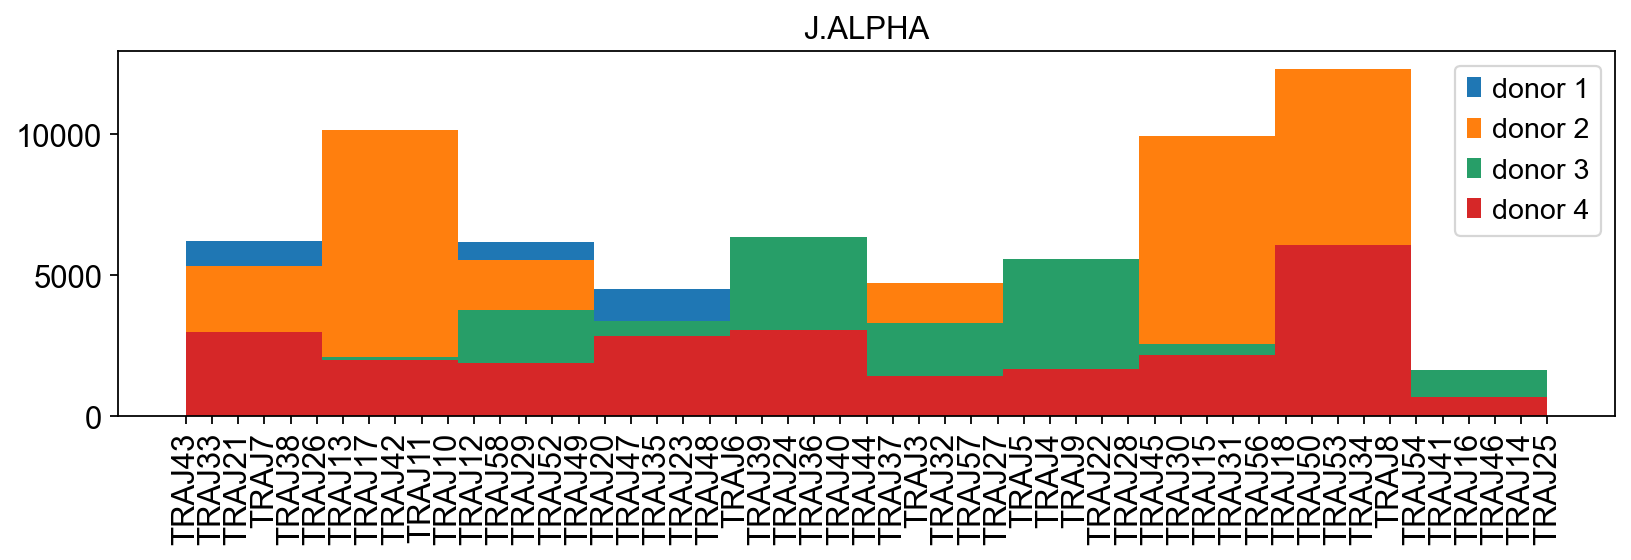

In [65]:
input_data=merged.copy()
for donor in range(1,5):
        df = input_data[input_data['subject:condition']=='donor%s:healthy'%(str(donor))]
        dups=len(df)-len(df.drop_duplicates())
        nans = len(df)-len(df.dropna())
        print('Removing %s duplicates and %s NaNs for donor %s'%(dups,nans,donor))

input_data=input_data.dropna().drop_duplicates()
for variable in ['v.beta','j.beta','v.alpha','j.alpha']:
    plt.figure(figsize=(12,3))
    for donor in range(1,5):
        df = input_data[input_data['subject:condition']=='donor%s:healthy'%(str(donor))]
        plt.hist(df[variable].values.astype(str),label='donor %s'%(donor))
    plt.grid(False)
    plt.xticks(rotation=90)
    plt.title(variable.upper())
    
    plt.legend()
    plt.show()
    

In [18]:
header=['tcr_outfile','contigs','bc_matrix','binarized_matrix','preprocess','min_cells','min_genes','max_genes','mito_cutoff','epitopes_loadfile','epitopes_outfile','h5_outfile','subj','organism','cluster_distance']
with open('data/record_merged.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(header)